In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
import string
import xml.etree.ElementTree as et
import helper_functions

# Georgia 2020 Statewide Election Results

This file builds off of VEST's 2020 Georgia election results file and adds in an additional 3 statewide races that VEST did not include.

## Election Results Documentation:

Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

## Shapefile Source Documentation:

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  
Cobb, DeKalb, and Gwinnett counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program.  
Forsyth and Fulton use shapefiles sourced from the respective counties.

## Shapefile Modifications Documentation:

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election.

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary  
Bartow: Split Cassville/Hamilton Crossing  
Candler: Merge Candler/Metter as Jack Strickland Comm Center  
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C  
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile  
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5   
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B  
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps  
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre  
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035  
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits   
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G  
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU  
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits  
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019  
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman  
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps  
Towns: Merge Macedonia/Tate City  
Wilkes: Align 1/2A boundary with the voter file    
Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

## Candidate List

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
C20PRERTRU - Donald J. Trump (Republican Party)  
C20PREDBID - Joseph R. Biden (Democratic Party)  
C20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
G20USSRPER - David A. Perdue (Republican Party)  
G20USSDOSS - Jon Ossoff (Democratic Party)  
G20USSLHAZ - Shane Hazel (Libertarian Party)  
  
S20USSRLOE - Kelly Loeffler (Republican Party)  
S20USSRCOL - Doug Collins (Republican Party)  
S20USSRGRA - Derrick E. Grayson (Republican Party)  
S20USSRJAC - Annette Davis Jackson (Republican Party)  
S20USSRTAY - Kandiss Taylor (Republican Party)  
S20USSRJOH - A. Wayne Johnson (Republican Party)  
S20USSDWAR - Raphael Warnock (Democratic Party)  
S20USSDJAC - Deborah Jackson (Democratic Party)  
S20USSDLIE - Matt Lieberman (Democratic Party)  
S20USSDJOH - Tamara Johnson-Shealey (Democratic Party)  
S20USSDJAM - Jamesia James (Democratic Party)  
S20USSDSLA - Joy Felicia Slade (Democratic Party)  
S20USSDWIN - Richard Dien Winfield (Democratic Party)  
S20USSDTAR - Ed Tarver (Democratic Party)  
S20USSLSLO - Brian Slowinski (Libertarian Party)  
S20USSGFOR - John Fortuin (Green Party)  
S20USSIBUC - Allen Buckley (Independent)  
S20USSIBAR - Al Bartell (Independent)  
S20USSISTO - Valencia Stovall (Independent)  
S20USSIGRE - Michael Todd Greene (Independent)  
  
G20PSCRSHA - Jason Shaw (Republican Party)  
G20PSCDBRY - Robert G. Bryant (Democratic Party)  
G20PSCLMEL - Elizabeth Melton (Libertarian Party)  
  
G20PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
G20PSCDBLA - Daniel Blackman (Democratic Party)  
G20PSCLWIL - Nathan Wilson (Libertarian Party)  

R21USSRPER - David A. Perdue (Republican Party)  
R21USSDOSS - Jon Ossoff (Democratic Party)  

R21USSRLOE - Kelly Loeffler (Republican Party)  
R21USSDWAR - Raphael Warnock (Democratic Party)  

R21PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
P21PSCDBLA - Daniel Blackman (Democratic Party) 

### Note - The below were added by us

G20A01YES - Amendment #1 "Yes"  
G20A01NO - Amendment #1 "No"   

G20A02YES - Amendment #2 "Yes"  
G20A02NO - Amendment #2 "No"  

G20RFAYES - Referendum A "Yes"  
G20RFANO - Referendum A "No"  

## Create the Modified VEST file

### Load the VEST file

In [2]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/ga_2020/ga_2020.shp")
print(vest_ga_20.shape)

(2679, 50)


### Replace Bibb County

Note: VEST appears to have used a slightly incorrect version of the shapefile here and not the official shapefile from the county.

In [3]:
# Filter out the Bibb portion of VEST's shapefile
vest_bibb = vest_ga_20[vest_ga_20["FIPS2"]=="021"]

# Get the remaining piece of VEST's shapefile
vest_no_bibb = vest_ga_20[vest_ga_20["FIPS2"]!="021"]
vest_no_bibb.reset_index(inplace = True, drop = True)

# Load the Bibb County shapefile
bibb_county_shp = gp.read_file("./raw-from-source/Shapefiles/Bibb/Voting_Precinct-shp/Voting_Precinct.shp")

bibb_county_shp = bibb_county_shp.to_crs(vest_ga_20.crs)

<AxesSubplot:>

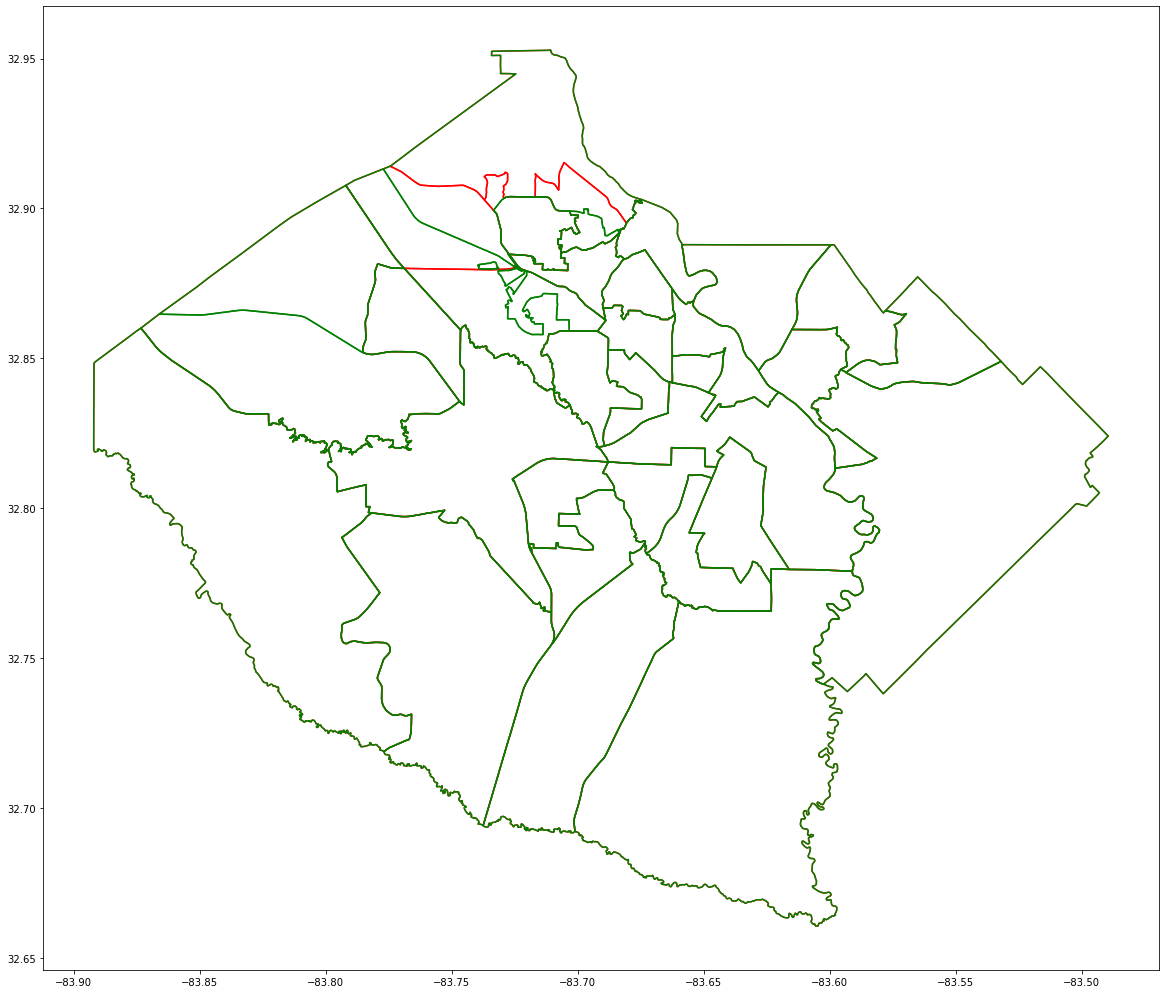

In [4]:
# Plot and compare the two maps
ax = bibb_county_shp.boundary.plot(figsize = (20,20), color = "red")
vest_bibb.boundary.plot(ax = ax, color = "green")

### Join the two together and replace the geometries

In [5]:
# Create the join column in the Bibb County shapefile
bibb_county_shp["DISTRICT"] = "021"+bibb_county_shp["POLLINGID"]

In [6]:
joined_bibb = pd.merge(bibb_county_shp, vest_bibb, how = "outer", on = "DISTRICT", indicator = True)

# Note the values join cleanly
print(joined_bibb["_merge"].value_counts())

joined_bibb.drop(["_merge", "geometry_y"], axis = 1, inplace = True)

joined_bibb.rename(columns = {'geometry_x':'geometry'}, inplace = True)

joined_bibb = gp.GeoDataFrame(joined_bibb, crs = vest_ga_20.crs)
joined_bibb = joined_bibb[list(vest_ga_20.columns)]

vest_ga_20 = gp.GeoDataFrame(pd.concat([joined_bibb, vest_no_bibb]), crs = vest_ga_20.crs)
vest_ga_20.reset_index(inplace = True, drop = True)

both          31
left_only      0
right_only     0
Name: _merge, dtype: int64


### Combine Northgate Assembly/Trinity

These precincts are combined for standardization purposes across the four files we are creating. The location of congressional votes in these two precincts, where on precinct is outside of a congressional district it has votes for creates issues, so this split is undone

In [7]:
# Separate out the Northgate Assembly / Trinity Precincts
to_combine = vest_ga_20[vest_ga_20["PRECINCT_N"].isin(['TRINITY', "NORTHGATE ASSEMBLY"])]
remaining_vest = vest_ga_20[~(vest_ga_20["PRECINCT_N"].isin(['TRINITY', "NORTHGATE ASSEMBLY"]))]

# Spatially combine the precincts and clean up the index
to_combine["dissolve"] = 1
to_combine_dissolved = to_combine.dissolve(["dissolve"], aggfunc = sum)
to_combine_dissolved.reset_index(inplace = True, drop = True)

# Give the combined precincts the appropriate values
to_combine_dissolved["DISTRICT"] = '185012'
to_combine_dissolved["CTYSOSID"] = '185012'
to_combine_dissolved["PRECINCT_I"] = '012'
to_combine_dissolved["PRECINCT_N"] = 'NORTHGATE ASSEMBLY AND TRINITY'
to_combine_dissolved["CTYNAME"] = 'LOWNDES'
to_combine_dissolved["CTYNUMBER"] = '92'
to_combine_dissolved["CTYNUMBER2"] = '092'
to_combine_dissolved["FIPS2"] = '185'

# Filter down to the relevant columns
to_combine_dissolved = to_combine_dissolved[list(vest_ga_20.columns)]

# Create the full-state precinct shapefile again and clean the index
vest_ga_20 = gp.GeoDataFrame(pd.concat([remaining_vest, to_combine_dissolved]), crs = vest_ga_20.crs)
vest_ga_20.reset_index(inplace = True, drop = True)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Export this file so it can be used in the other notebooks

In [8]:
vest_ga_20.to_file("./raw-from-source/VEST/cleaned_ga_2020/cleaned_ga_2020.shp")

vest_ga_20 = gp.read_file("./raw-from-source/VEST/cleaned_ga_2020/cleaned_ga_2020.shp")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Look at the VEST file

In [9]:
# Take a look
vest_ga_20.head(1)

#Create a list of the race columns
data_columns = [i for i in vest_ga_20.columns if (("20" in i) | ("21" in i))]
print(data_columns)

['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN', 'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR', 'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL', 'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS', 'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA']


## Election Results Processing

### 1. Load General Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [10]:
loaded_counties = os.listdir("./raw-from-source/Non_Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Non_Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_general = pd.DataFrame(z,columns=dfcols)

In [11]:
df_general["contest"].unique()

array(['President of the United States', 'US Senate (Perdue)',
       'US Senate (Loeffler) - Special',
       'Public Service Commission District 1',
       'Public Service Commission District 4', 'US House District 2',
       'State Senate District 13', 'State House District 148',
       'Probate Judge', 'Clerk of Superior Court', 'Sheriff',
       'Tax Commissioner', 'Coroner', 'Chief Magistrate',
       'County Commission Dist 1 Post 2',
       'County Commission Dist 2 Post 1',
       'Board of Education At Large - Cordele',
       'Board of Education At Large - West Crisp',
       'Soil and Water - Middle South Georgia',
       'Constitutional Amendment #1', 'Constitutional Amendment #2',
       'Statewide Referendum A', 'US House District 1',
       'State Senate District 1', 'State House District 160',
       'State House District 164', 'State House District 166',
       'Solicitor General', 'County Commission Chair',
       'County Commission District 1', 'County Commission Di

### Join Election Data Together

In [12]:
ga_election = df_general.copy(deep = True)

#Sanity check that there are the right number of counties
print(len(ga_election["county"].unique()))

# Clean the contest name
ga_election["contest"] = ga_election["contest"].str.strip()

159


### Filter Down to Relevant Races

In [13]:
other_statewide_races = ["Constitutional Amendment #2",
                         "Constitutional Amendment #1",
                         "Statewide Referendum A",
                        'Constitutional Amendment #1/Propuestas de Enmienda Constitucional #1',
                        'Constitutional Amendment #2/Propuestas de Enmienda Constitucional #2',
                        'Statewide Referendum A/Propuesta de Referéndum Estatal A']

In [14]:
ga_election = ga_election[ga_election["contest"].isin(other_statewide_races)]

In [15]:
# Clean up the names that are written in Spanish
contest_changes_dict = {
    'Constitutional Amendment #1/Propuestas de Enmienda Constitucional #1':'Constitutional Amendment #1',
    'Constitutional Amendment #2/Propuestas de Enmienda Constitucional #2':'Constitutional Amendment #2',
    'Statewide Referendum A/Propuesta de Referéndum Estatal A':'Statewide Referendum A'
}

ga_election["contest"] = ga_election["contest"].map(contest_changes_dict).fillna(ga_election["contest"])

# Reset the index after the above filter
ga_election.reset_index(inplace=True,drop=True)

### Clean and Pivot Data

In [16]:
list(ga_election["contest"].unique())

['Constitutional Amendment #1',
 'Constitutional Amendment #2',
 'Statewide Referendum A']

In [17]:
# Cast the votes to an integer
ga_election["num_votes"] = ga_election["num_votes"].astype(int)

#### Add a FIPS Column

In [18]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)

# Print statements to check the county FIPs we've added
print(ga_election['county_fips'].unique())

['081' '029' '027' '017' '219' '245' '275' '277' '239' '221' '095' '105'
 '107' '003' '103' '033' '273' '251' '249' '271' '113' '025' '083' '021'
 '037' '263' '257' '261' '265' '115' '099' '005' '009' '035' '101' '247'
 '269' '243' '241' '267' '253' '023' '111' '007' '131' '129' '183' '163'
 '287' '317' '315' '293' '177' '181' '045' '055' '125' '049' '077' '173'
 '193' '307' '283' '285' '309' '179' '175' '161' '133' '047' '071' '121'
 '137' '297' '295' '167' '189' '197' '165' '291' '305' '053' '117' '147'
 '059' '043' '303' '311' '191' '169' '159' '187' '313' '289' '123' '135'
 '073' '065' '201' '195' '149' '153' '067' '151' '141' '301' '299' '057'
 '069' '145' '127' '139' '075' '319' '321' '157' '063' '051' '155' '143'
 '171' '185' '061' '079' '011' '119' '259' '199' '237' '001' '235' '207'
 '255' '039' '091' '087' '089' '231' '209' '205' '233' '015' '085' '097'
 '229' '213' '211' '227' '019' '031' '093' '215' '223' '279' '281' '225'
 '217' '013' '109']


### Clean Candidate Names

#### Pivot the data

In [19]:
# Define a unique_ID column
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]

# Add in the vote type (Yes or No) for each contest
ga_election["choice"]=ga_election["choice"]+ga_election["contest"]

# Perform the pivot, clean the resulting dataframe
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

#### Change Names to match VEST

In [20]:
column_changes_dict = {
       'NOConstitutional Amendment #1':'G20A01NO',
       'NOConstitutional Amendment #2':'G20A02NO',
       'NOStatewide Referendum A':'G20RFANO',
       'YESConstitutional Amendment #1':'G20A01YES',
       'YESConstitutional Amendment #2':'G20A02YES',
       'YESStatewide Referendum A':'G20RFAYES'
}

In [21]:
ga_election = ga_election.rename(columns=column_changes_dict)

In [22]:
#Create a matching "FIPS2" column in the election results
ga_election["county_fips"] = ga_election["county_fips"].astype(int).astype(str).str.zfill(3)
ga_election["FIPS2"] = ga_election["county_fips"]

vest_ga_20["FIPS2"] = vest_ga_20["FIPS2"].astype(str)

## Join Election Results to VEST

#### Try a  unique ID

In [23]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

#### Check whether there are duplicate IDs

In [24]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
NaN                        7
051-ELI WHITNEY COMPLEX    2
Name: unique_ID, dtype: int64


In [25]:
#Look into duplicate IDs - ELI WHITNEY
display(vest_ga_20[vest_ga_20["unique_ID"]=="051-ELI WHITNEY COMPLEX"])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,G20PSCDBLA,G20PSCLWIL,R21USSRPER,R21USSDOSS,R21USSRLOE,R21USSDWAR,R21PSCRMCD,R21PSCDBLA,geometry,unique_ID
2259,0513-15C,0513-15C,3-15C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,278,361,...,325,15,281,329,282,329,284,318,"POLYGON ((-81.02948 32.06200, -81.03000 32.060...",051-ELI WHITNEY COMPLEX
2261,0512-06C,0512-06C,2-06C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,65,335,...,301,19,52,312,53,311,54,300,"POLYGON ((-81.05333 32.07291, -81.05336 32.072...",051-ELI WHITNEY COMPLEX


In [26]:
#Assign new unique IDs, adding in PRECINCT_I to differentiate
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

# For the other NA values, use the DISTRICT as the unique_ID
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']

#### Confirm there are no duplicate IDs

In [27]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
Series([], Name: unique_ID, dtype: int64)


In [28]:
#First join attempt
join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

both          2543
right_only     135
left_only      113
Name: _merge, dtype: int64


## Combine the Northgate / Trinity Precincts in the Election Results

Note: This will match the combining of the precincts we did above

In [29]:
# Separate out the precincts
to_remove = ga_election[(ga_election["county"]=="Lowndes") & (ga_election["precinct"].isin(["NORTHGATE ASSEMBLY", "TRINITY"]))]
remaining_elections = ga_election[~((ga_election["county"]=="Lowndes") & (ga_election["precinct"].isin(["NORTHGATE ASSEMBLY", "TRINITY"])))]

# Print statements to make sure the above is correct
print(ga_election.shape)
print(remaining_elections.shape)
print(to_remove.shape)

(2656, 11)
(2654, 11)
(2, 11)


In [30]:
# Combine the election results in Northgate / Trinity
grouped_to_remove = to_remove.groupby(["county_fips"]).sum()
grouped_to_remove.reset_index(inplace = True, drop = False)

# Give updated values to the relevant columns
grouped_to_remove["unique_ID"] = "185-NORTHGATE ASSEMBLY AND TRINITY"
grouped_to_remove["county"] = 'Lowndes'
grouped_to_remove["county_fips"] = '185' 
grouped_to_remove["precinct"] = 'NORTHGATE ASSEMBLY AND TRINITY'
grouped_to_remove["FIPS2"] = '185' 

# Filter down to the relevant columns
grouped_to_remove = grouped_to_remove[list(to_remove.columns)]

# Group all the precincts back together
ga_election = pd.concat([remaining_elections, grouped_to_remove])
ga_election.reset_index(inplace = True, drop = False)

### Change Precinct Names to Match VEST

In [31]:
#Create a dictionary of ID changes
source_vest_id_changes_dict = {'051-1-17C ISLANDS CHRISTIAN CHURCH': '051-ISLANDS CHRISTIAN CHURCH', '051-7-14C COASTAL CATHEDRAL': '051-COASTAL CATHEDRAL', '051-7-07C ROTHWELL BAPTIST CHURCH': '051-ROTHWELL BAPTIST CHURCH', '051-4-07C WILMINGTON ISLAND UMC': '051-WILMINGTON ISLAND UMC', '051-4-08C WILMINGTON ISLAND PRES CHURCH': '051-WILMINGTON ISLAND PRES CHURCH', '051-1-16C FERGUSON AVE BAPTIST': '051-FERGUSON AVE BAPTIST', '051-7-11C SEVENTH DAY ADV CHURCH': '051-SEVENTH DAY ADV CHURCH', '051-7-16C POOLER RECREATION CENTER GYMNASIUM': '051-POOLER REC CENTER GYM', '051-7-08C BLOOMINGDALE COMM CTR': '051-BLOOMINGDALE COMM CTR', '051-4-13C SKIDAWAY ISLAND PRES CHURCH': '051-SKIDAWAY ISLAND PRES CHURCH', '051-6-10C STATION 3': '051-GEORGETOWN ELEMENTARY', '051-4-12C ST PETERS EPISCOPAL': '051-ST PETERS EPISCOPAL', '051-7-13C SOUTHSIDE FIRE TRNG CTR': '051-SOUTHSIDE FIRE TRNG CTR', '051-4-06C FIRST BAPTIST OF THE ISLAND': '051-FIRST BAPTIST OF THE ISLAND', '051-4-04C LIGHTHOUSE BAPTIST CHURCH': '051-LIGHTHOUSE BAPTIST CHURCH', '051-4-05C ST FRANCIS EPISCOPAL CHURCH': '051-ST FRANCIS EPISCOPAL CHURCH', '051-1-12C ISLE OF HOPE BAPTIST': '051-ISLE OF HOPE BAPTIST', '051-4-02C FRANK MURRAY COMM CENTER': '051-FRANK MURRAY COMM CENTER', '051-7-06C POOLER CITY HALL': '051-POOLER CITY HALL', '051-8-16C ROYAL CINEMAS AND IMAX': '051-ROYAL CINEMAS AND IMAX', '051-6-02C WINDSOR FOREST BAPTIST': '051-WINDSOR FOREST BAPTIST', '051-6-11C BAMBOO FARMS': '051-BAMBOO FARMS', '051-4-15C SKIDAWAY ISLAND STATE PARK': '051-SKIDAWAY ISLAND STATE PARK', '051-6-09C TRINITY LUTHERAN CHURCH': '051-TRINITY LUTHERAN CHURCH', '051-1-01C FIRST PRESBYTERIAN CHURCH': '051-FIRST PRESBYTERIAN CHURCH', '051-4-14C SKIDAWAY ISLAND BAPTIST': '051-SKIDAWAY ISLAND BAPTIST', '051-7-12C POOLER CHURCH': '051-POOLER CHURCH', '051-7-10C PROGRESSIVE REC CENTER': '051-PROGRESSIVE REC CENTER', '051-1-06C CENTRAL CHURCH OF CHRIST': '051-CENTRAL CHURCH OF CHRIST', '051-1-14C COMPASSION CHRISTIAN CHURCH': '051-COMPASSION CHRISTIAN CHURCH', '051-6-03C CRUSADER COMM CENTER': '051-CRUSADER COMM CENTER', '051-4-11C TYBEE ISLAND SCHOOL CAFE': '051-TYBEE ISLAND SCHOOL CAFE', '051-7-09C SAVANNAH HOLY C OF G': '051-SAVANNAH HOLY C OF G', '051-4-10C GUARD HOUSE COMM CTR': '051-GUARD HOUSE COMM CTR', '051-1-08C GRACE UNITED METHODIST CHURCH': '051-GRACE UNITED METHODIST CHURCH', '051-1-10C ST THOMAS EPISCOPAL CHURCH': '051-ST THOMAS EPISCOPAL CHURCH', '051-1-05C JEA BUILDING': '051-JEA BUILDING', '051-1-13C THE SANCTUARY': '051-THE SANCTUARY', '051-7-15C RICE CREEK SCHOOL': '051-RICE CREEK SCHOOL', '051-3-12C THUNDERBOLT MUNI COMPLEX': '051-THUNDERBOLT MUNI COMPLEX', '051-3-13C NEW COV 7 DAY ADV CH': '051-NEW COV 7 DAY ADV CH', '051-7-03C PB EDWARDS GYM': '051-PB EDWARDS GYM', '051-7-01C GARDEN CITY SENIOR CTR': '051-GARDEN CITY SENIOR CTR', '051-6-06C THE LIGHT CHURCH': '051-THE LIGHT CHURCH', '051-7-04C LAKE SHORE COMM CTR': '051-LAKE SHORE COMM CTR', '051-6-05C WINDSOR HALL': '051-WINDSOR HALL', '051-3-02C TEMPLE MICKVE ISRAEL': '051-TEMPLE MICKVE ISRAEL', '051-6-01C WHITE BLUFF PRESBYTERIAN': '051-WHITE BLUFF PRESBYTERIAN', '051-5-11C LARGO-TIBET ELEMENTARY': '051-LARGO-TIBET ELEMENTARY', '051-3-14C OGLETHORPE CHARTER ACADEMY': '051-OGLETHORPE CHARTER ACADEMY', '051-6-08C CHRIST MEMORIAL BAPTIST CHURCH': '051-CHRIST MEMORIAL BAPTIST CHURCH', '051-7-05C WOODLAWN BAPTIST CHURCH': '051-WOODLAWN BAPTIST CHURCH', '051-5-08C SAVANNAH PRIMITIVE BC': '051-SAVANNAH PRIMITIVE BC', '051-8-03C SILK HOPE BAPTIST CHURCH': '051-SILK HOPE BAPTIST CHURCH', '051-3-05C ALDERSGATE YOUTH CENTER': '051-ALDERSGATE YOUTH CENTER', '051-3-09C COKESBURY METHODIST': '051-COKESBURY METHODIST', '051-3-15C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 3-15C', '051-8-13C SAVANNAH CHRISTIAN': '051-SAVANNAH CHRISTIAN', '051-5-07C STATION 1': '051-ELKS LODGE', '051-2-09C SALVATION ARMY': '051-SALVATION ARMY', '051-3-10C BIBLE BAPTIST CHURCH': '051-BIBLE BAPTIST CHURCH', '051-2-07C CHRIST COMMUNITY CHURCH': '051-CHRIST COMMUNITY CHURCH', '051-3-08C JENKINS HIGH SCHOOL': '051-JENKINS HIGH SCHOOL', '051-5-06C SEED CHURCH': '051-SEED CHURCH', '051-1-09C IMMANUEL BAPTIST CHURCH': '051-IMMANUEL BAPTIST CHURCH', '051-8-02C HELLENIC CENTER': '051-HELLENIC CENTER', '051-2-11C STILLWELL TOWERS': '051-STILLWELL TOWERS', '051-3-11C SOUTHSIDE BAPTIST CHURCH': '051-SOUTHSIDE BAPTIST CHURCH', '051-2-02C BLACKSHEAR COMMUNITY CENTER': '051-BLACKSHEAR COMMUNITY CENTER', '051-5-01C BARTLETT MIDDLE SCHOOL': '051-BARTLETT MIDDLE SCHOOL', '051-2-05C HOLY SPIRIT LUTHERAN CHURCH': '051-HOLY SPIRIT LUTHERAN CHURCH', '051-2-04C FELLOWSHIP OF LOVE CHURCH': '051-FELLOWSHIP OF LOVE CHURCH', '051-2-12C WILLIAMS COURT APTS': '051-WILLIAMS COURT APTS', '051-3-01C OLD COURTHOUSE': '051-OLD COURTHOUSE', '051-2-03C W W LAW CENTER': '051-W W LAW CENTER', '051-8-12C BEACH HIGH SCHOOL': '051-BEACH HIGH SCHOOL', '051-5-10C TATUMVILLE COMMUNITY CENTER': '051-TATUMVILLE COMMUNITY CENTER', '051-8-15C GARDEN CITY REC CENTER': '051-GARDEN CITY REC CENTER', '051-2-06C ELI WHITNEY COMPLEX': '051-ELI WHITNEY COMPLEX 2-06C', '051-3-03C SAVANNAH HIGH SCHOOL': '051-SAVANNAH HIGH SCHOOL', '051-8-01C CIVIC CENTER': '051-CIVIC CENTER', '051-3-04C FIRST AFRICAN BAPTIST CHURCH': '051-FIRST AFRICAN BAPTIST CHURCH', '051-5-05C LIBERTY CITY COMM CTR': '051-LIBERTY CITY COMM CTR', '051-5-02C SENIOR CITIZENS CENTER': '051-SENIOR CITIZENS CENTER', '051-8-08C RESUR OF OUR LORD CHURCH': '051-RESURRECTION OF OUR LORD CHURCH', '051-8-05C W BROAD ST YMCA': '051-W BROAD ST YMCA', '051-8-06C TOMPKINS REC CENTER': '051-TOMPKINS REC CENTER', '051-8-09C MOSES JACKSON CENTER': '051-MOSES JACKSON CENTER', '051-5-03C BUTLER PRESBYTERIAN CHURCH': '051-BUTLER PRESBYTERIAN CHURCH', '051-8-11C BUTLER ELEMENTARY': '051-BUTLER ELEMENTARY', '051-8-07C WOODVILLE-TOMPKINS TI': '051-WOODVILLE-TOMPKINS TI', '051-8-10C CARVER HEIGHTS COMM CTR': '051-CARVER HEIGHTS COMM CTR', '053-ACTIVITY CENTER': '053-ACTIVITY CENTER (Includes FTBEN 1-3)', '067-POWDERS SPRINGS 1A': '067-POWDER SPRINGS 1A', '067-POWDERS SPRINGS 2A': '067-POWDER SPRINGS 2A', '067-POWDERS SPRINGS 3A': '067-POWDER SPRINGS 3A', '171-CHAPPELL MILL V FD': '171-CHAPPELL MILL VFD', '275-LITTLE OCHLOCKNEE BAPTIST CHURCH': '275-LITTLE OCHLOCKNEE', '299-100': '299-District 1', '299-200A': '299-District 2A', '299-200B': '299-District 2B', '299-300': '299-1231-150B', '299-304': '299-1231-150C', '299-400': '299-1231-151', '299-404': '299-Beach-Bickley', '299-405': '299-Haywood', '299-406': '299-Jamestown', '299-407': '299-Manor', '299-408': '299-Millwood', '299-409': '299-Waresboro', '317-TIGNAL SCH LUNCH RM': '317-TIGNALL SCH LUNCH RM'}

#Apply the changes
ga_election["unique_ID"] = ga_election["unique_ID"].map(source_vest_id_changes_dict).fillna(ga_election["unique_ID"])

In [32]:
#Second join attempt
join_attempt_2 = pd.merge(vest_ga_20,ga_election,how="outer",on="unique_ID",indicator=True)
print(join_attempt_2["_merge"].value_counts())

both = join_attempt_2[join_attempt_2["_merge"]=="both"]
left_only = join_attempt_2[join_attempt_2["_merge"]=="left_only"]
right_only = join_attempt_2[join_attempt_2["_merge"]=="right_only"]

both          2655
left_only       23
right_only       0
Name: _merge, dtype: int64


### Look into unjoined precincts

Note: They all appear to contain zero votes

In [33]:
#Confirm that the unjoined precincts contain zero-votes
empty_precincts = []
for index, row in left_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

23


### Clean the joined dataframe

In [34]:
# Cast the vote columns we added to integer
newcolumn_list = ['G20A01YES','G20A01NO','G20A02YES','G20A02NO', 'G20RFAYES','G20RFANO']
for col in newcolumn_list:
    join_attempt_2[col]=join_attempt_2[col].fillna(0)
    join_attempt_2[col]=join_attempt_2[col].astype(int)

In [35]:
# Rename the fips column to match VEST
join_attempt_2.rename(columns={'unique_ID':'UNIQUE_ID','FIPS2_x':'FIPS2', 'county_fips':'COUNTYFP'},inplace=True)

In [36]:
join_attempt_2.columns

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA', 'geometry',
       'UNIQUE_ID', 'index', 'county', 'COUNTYFP', 'precinct', 'G20A01NO',
       'G20A02NO', 'G20RFANO', 'G20A01YES', 'G20A02YES', 'G20RFAYES',
       'FIPS2_y', '_merge'],
      dtype='object')

In [37]:
# Filter down to the appropriate levels
join_attempt_2 = join_attempt_2[['UNIQUE_ID',"COUNTYFP",'DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2','G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA','G20A01YES','G20A01NO','G20A02YES','G20A02NO', 'G20RFAYES','G20RFANO','geometry']]

## Check Added Column Totals

In the 'statewide-county-totals-check-erj' we created a cleaned csv of the county totals from the GA sos website

In [38]:
official_county_totals = pd.read_csv("./cleaned_official_county_totals.csv")

In [39]:
helper_functions.statewide_totals_check(official_county_totals, "Official Totals", join_attempt_2, "ERJ Totals", newcolumn_list)

***Statewide Totals Check***
G20A01YES is equal 	 both dataframes 3862568
G20A01NO is equal 	 both dataframes 869540
G20A02YES is equal 	 both dataframes 3491296
G20A02NO is equal 	 both dataframes 1197792
G20RFAYES is equal 	 both dataframes 3451116
G20RFANO is equal 	 both dataframes 1270737


The following totals also match what is on the GA sos website
- G20A01YES: 3862568
- G20A01NO: 869540
- G20A02YES: 3491296
- G20A02NO: 1197792
- G20RFAYES: 3451116
- G20RFANO: 1270737

## Check Column Totals - County Level

In [40]:
official_county_totals["CTYNAME"] = official_county_totals["county"].str.upper()

In [41]:
helper_functions.county_totals_check(official_county_totals, "Official Totals", join_attempt_2, "ERJ Totals", newcolumn_list, "CTYNAME")

***Countywide Totals Check***

G20A01YES is equal across all counties
G20A01NO is equal across all counties
G20A02YES is equal across all counties
G20A02NO is equal across all counties
G20RFAYES is equal across all counties
G20RFANO is equal across all counties


The totals also match at the county level

### Create Fields Dict

In [42]:
fields_string = '''G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
C20PRERTRU - Donald J. Trump (Republican Party)  
C20PREDBID - Joseph R. Biden (Democratic Party)  
C20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20USSRPER - David A. Perdue (Republican Party)  
G20USSDOSS - Jon Ossoff (Democratic Party)  
G20USSLHAZ - Shane Hazel (Libertarian Party)  
S20USSRLOE - Kelly Loeffler (Republican Party)  
S20USSRCOL - Doug Collins (Republican Party)  
S20USSRGRA - Derrick E. Grayson (Republican Party)  
S20USSRJAC - Annette Davis Jackson (Republican Party)  
S20USSRTAY - Kandiss Taylor (Republican Party)  
S20USSRJOH - A. Wayne Johnson (Republican Party)  
S20USSDWAR - Raphael Warnock (Democratic Party)  
S20USSDJAC - Deborah Jackson (Democratic Party)  
S20USSDLIE - Matt Lieberman (Democratic Party)  
S20USSDJOH - Tamara Johnson-Shealey (Democratic Party)  
S20USSDJAM - Jamesia James (Democratic Party)  
S20USSDSLA - Joy Felicia Slade (Democratic Party)  
S20USSDWIN - Richard Dien Winfield (Democratic Party)  
S20USSDTAR - Ed Tarver (Democratic Party)  
S20USSLSLO - Brian Slowinski (Libertarian Party)  
S20USSGFOR - John Fortuin (Green Party)  
S20USSIBUC - Allen Buckley (Independent)  
S20USSIBAR - Al Bartell (Independent)  
S20USSISTO - Valencia Stovall (Independent)  
S20USSIGRE - Michael Todd Greene (Independent)  
G20PSCRSHA - Jason Shaw (Republican Party)  
G20PSCDBRY - Robert G. Bryant (Democratic Party)  
G20PSCLMEL - Elizabeth Melton (Libertarian Party)  
G20PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
G20PSCDBLA - Daniel Blackman (Democratic Party)  
G20PSCLWIL - Nathan Wilson (Libertarian Party)  
R21USSRPER - David A. Perdue (Republican Party)  
R21USSDOSS - Jon Ossoff (Democratic Party)  
R21USSRLOE - Kelly Loeffler (Republican Party)  
R21USSDWAR - Raphael Warnock (Democratic Party)  
R21PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
P21PSCDBLA - Daniel Blackman (Democratic Party) 
G20A01YES - Amendment #1 "Yes"  
G20A01NO - Amendment #1 "No"   
G20A02YES - Amendment #2 "Yes"  
G20A02NO - Amendment #2 "No"  
G20RFAYES - Referendum A "Yes"  
G20RFANO - Referendum A "No"'''

In [43]:
first_split = fields_string.split("\n")
new_split = []
for val in first_split:
    val.strip()
    new_split.append(val.strip())

In [44]:
second_split = []
for val in new_split:
    second_split.append(val.split(" - "))

In [45]:
fields_df = pd.DataFrame(second_split, columns = ['Field_Name', 'Cand_Name'])

In [46]:
fields_df.to_csv("./cand_dicts/statewide_fields_dict.csv", index = False)

## Export the File

In [47]:
join_attempt_2.to_file("./ga_gen_20_prec/ga_gen_20_st_prec.shp")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
